In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch as to
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score



# Load Dataset #

In [58]:
df = pd.read_csv("data/finaldataset.csv")
df.head()

,backers_count,blurb,converted_pledged_amount,country_displayable_name,currency,current_currency,disable_communication,fx_rate,goal,id,...,usd_pledged,usd_type,month,is_in_post_campaign_pledging_phase,category_name,subcategory,city,year_month,year_month_final,state_changed_month
0,491,Fantasy playing card decks combine the structu...,36513.0,the United States,USD,USD,False,1.0,10000.0,1293,...,36513.0,international,2024-04-01,NaN,Games,Playing Cards,"Asheville, NC",2023-10,2023-10,2023-10
1,0,A heroine's first day on the job uncovers a te...,NaN,the United States,USD,USD,False,1.0,0.0,13583,...,NaN,international,2024-04-01,NaN,Comics,Comic Books,"Jersey City, NJ",2024-01,2024-11,2024-01
2,52,A heroine's first day on the job uncovers a te...,1471.0,the United States,USD,USD,False,1.0,500.0,13583,...,1471.0,domestic,2024-09-01,False,Comics,Comic Books,"Jersey City, NJ",2024-09,2024-11,2024-09
3,130,A heroine's first day on the job uncovers a te...,2869.0,the United States,USD,USD,False,1.0,500.0,13583,...,2869.0,domestic,2024-11-01,False,Comics,Comic Books,"Jersey City, NJ",2024-11,2024-11,2024-11
4,4,Raising money to help my grandmother recover f...,62.0,the United States,USD,USD,False,1.0,15000.0,18520,...,62.0,international,2024-04-01,NaN,Music,World Music,"Cleveland, OH",2016-11,2016-11,2016-11


In [59]:
df.columns

Index(['backers_count', 'blurb', 'converted_pledged_amount',
       'country_displayable_name', 'currency', 'current_currency',
       'disable_communication', 'fx_rate', 'goal', 'id', 'is_disliked',
       'is_launched', 'is_liked', 'is_starrable', 'launched_at', 'name',
       'percent_funded', 'pledged', 'prelaunch_activated', 'slug', 'spotlight',
       'staff_pick', 'state', 'state_changed_at', 'static_usd_rate',
       'usd_exchange_rate', 'usd_pledged', 'usd_type', 'month',
       'is_in_post_campaign_pledging_phase', 'category_name', 'subcategory',
       'city', 'year_month', 'year_month_final', 'state_changed_month'],
      dtype='object')

In [60]:
# Preview Data
print("Dataset shape:",df.shape)
print("Columns:",df.columns.tolist())
print("Sample Rows:")
print(df.head())

Dataset shape: (256378, 36)
Columns: ['backers_count', 'blurb', 'converted_pledged_amount', 'country_displayable_name', 'currency', 'current_currency', 'disable_communication', 'fx_rate', 'goal', 'id', 'is_disliked', 'is_launched', 'is_liked', 'is_starrable', 'launched_at', 'name', 'percent_funded', 'pledged', 'prelaunch_activated', 'slug', 'spotlight', 'staff_pick', 'state', 'state_changed_at', 'static_usd_rate', 'usd_exchange_rate', 'usd_pledged', 'usd_type', 'month', 'is_in_post_campaign_pledging_phase', 'category_name', 'subcategory', 'city', 'year_month', 'year_month_final', 'state_changed_month']
Sample Rows:
   backers_count                                              blurb  \
0            491  Fantasy playing card decks combine the structu...   
1              0  A heroine's first day on the job uncovers a te...   
2             52  A heroine's first day on the job uncovers a te...   
3            130  A heroine's first day on the job uncovers a te...   
4              4  Rais

## Convert TimeStamps ##

In [61]:
df["launched_at"] = pd.to_datetime(df["launched_at"],errors="coerce")
df["state_changed_at"] = pd.to_datetime(df["state_changed_at"],errors ="coerce")


In [62]:
# filter invalid timestamps. Remove 1970s and nulls

df = df[(df["launched_at"].dt.year > 2000) & (df["launched_at"].dt.year > 2000)]
# Remove duplicates

df = df.drop_duplicates(subset="id")

# Calculate campaign duration in months
df["months_to_final_state"] = (df["state_changed_at"]-df["launched_at"]).dt.days/30
df = df[df["months_to_final_state"]>0]

# Desired Final States

final_states = ["successful","failed","canceled","suspended"]

# Remove campaigns that start in the final state.
df = df[df["state"].isin(final_states)]

# Optional: encode success as 1/0 for modeling
df["final_state_numeric"] = df["state"].apply(lambda x: 1 if x == "successful" else 0)

# Preview clean data

print(df[["id","state","category_name","goal","pledged","backers_count","months_to_final_state"]].head())



        id       state category_name        goal  pledged  backers_count  \
22   74540      failed    Technology     53000.0    533.0              6   
30  115083      failed    Technology      3385.0   1386.0              4   
37  180802  successful           Art      4000.0   4066.0             48   
39  218406      failed  Film & Video  99000000.0     75.0              1   
45  310837      failed           Art      1200.0    608.0             11   

    months_to_final_state  
22               4.233333  
30               7.866667  
37               7.133333  
39              46.300000  
45              21.666667  


### Exploratory Data Analysis ###

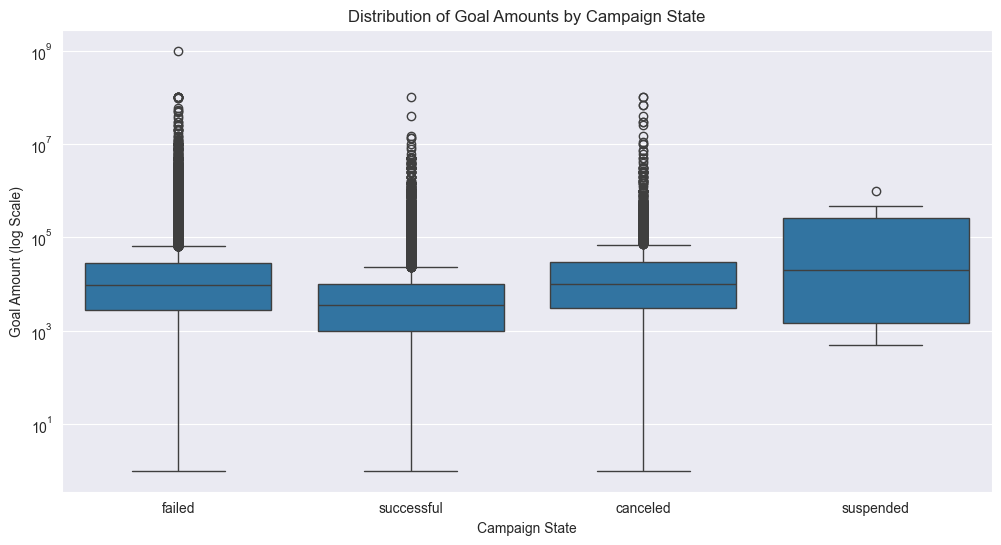

In [63]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df,x="state",y="goal")

plt.yscale("log")
plt.title("Distribution of Goal Amounts by Campaign State")
plt.xlabel("Campaign State")
plt.ylabel("Goal Amount (log Scale)")
plt.grid(True,axis="y")
plt.show()

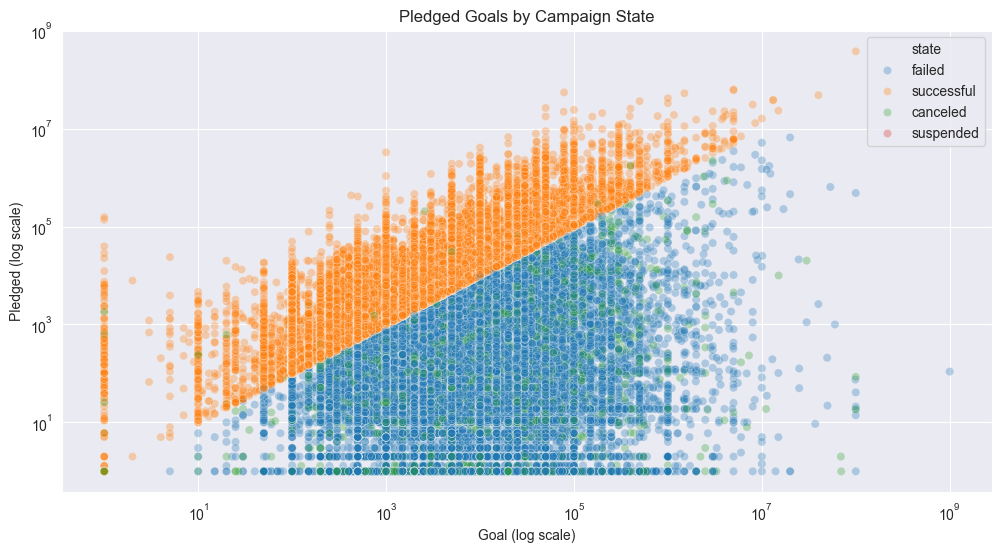

In [64]:
# Pledged vs. Goal with Outcome hue

plt.figure(figsize=(12,6))
sns.scatterplot(data=df,x="goal",y="pledged",hue="state",alpha=0.3)
plt.xscale("log")
plt.yscale("log")
plt.title("Pledged Goals by Campaign State")
plt.xlabel("Goal (log scale)")
plt.ylabel("Pledged (log scale)")
plt.grid(True)
plt.show()

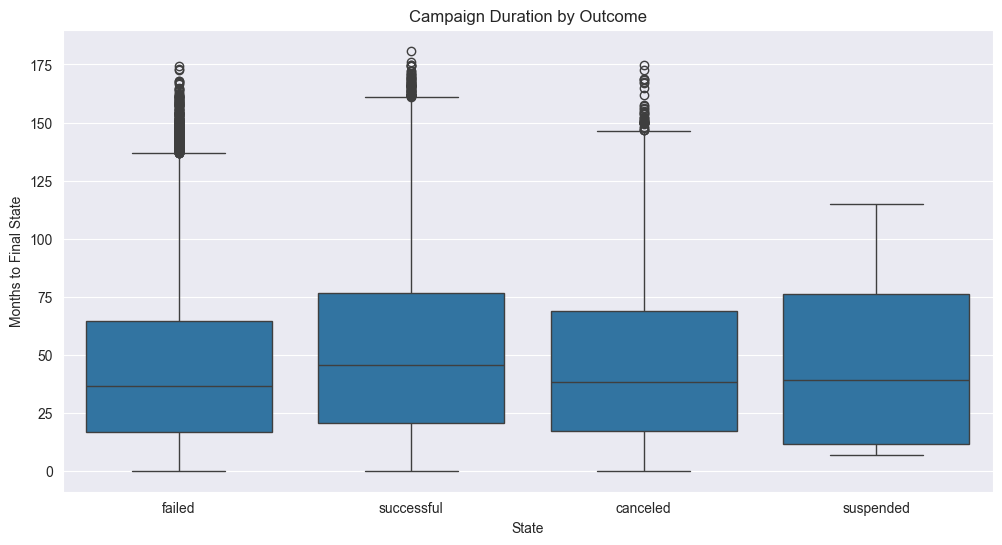

In [66]:
# Campaign Duration vs Outcome

plt.figure(figsize=(12,6))
sns.boxplot(data=df,x="state",y="months_to_final_state")
plt.title("Campaign Duration by Outcome")
plt.xlabel("State")
plt.ylabel("Months to Final State")
plt.grid(True,axis="y")
plt.show()

### Feature Engineering ###

In [67]:
# 1. Let's create a pledge to success ratio

df["pledged_success_ratio"] = df["pledged"]/df["goal"]
df["pledged_success_ratio"].replace([np.inf,-np.inf],np.nan,inplace=True) # Handles divisions by zero
df["pledged_success_ratio"].fillna(0,inplace=True) #fills in any missing values with 0

# Add a binary success label (1 = successful, 0 = all other final states)

df["success"] = df["state"].apply(lambda x: 1 if x == "successful" else 0)

# Bin months to final state in categories

def categorize_duration(months):
    if months<3:
        return "short"
    elif months<9:
        return "medium"
    else:
        return "long"

df['duration_bin'] = df["months_to_final_state"].apply(categorize_duration)

# Log transformed versions of skewed features

df["log_goal"] = np.log1p(df["goal"])
df["log_pledged"] = np.log1p(df["pledged"])
df["log_backers"] = np.log1p(df["backers_count"])





/var/folders/pd/p7n06std6nj_26fw2tft4t700000gn/T/ipykernel_93462/691624180.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["pledged_success_ratio"].replace([np.inf,-np.inf],np.nan,inplace=True) # Handles divisions by zero
/var/folders/pd/p7n06std6nj_26fw2tft4t700000gn/T/ipykernel_93462/691624180.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the inte

## Visualization of Engineered Featured ##

/var/folders/pd/p7n06std6nj_26fw2tft4t700000gn/T/ipykernel_93462/1828347710.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=success_rate_by_duration,x="duration_bin",y="success",palette="Set2")


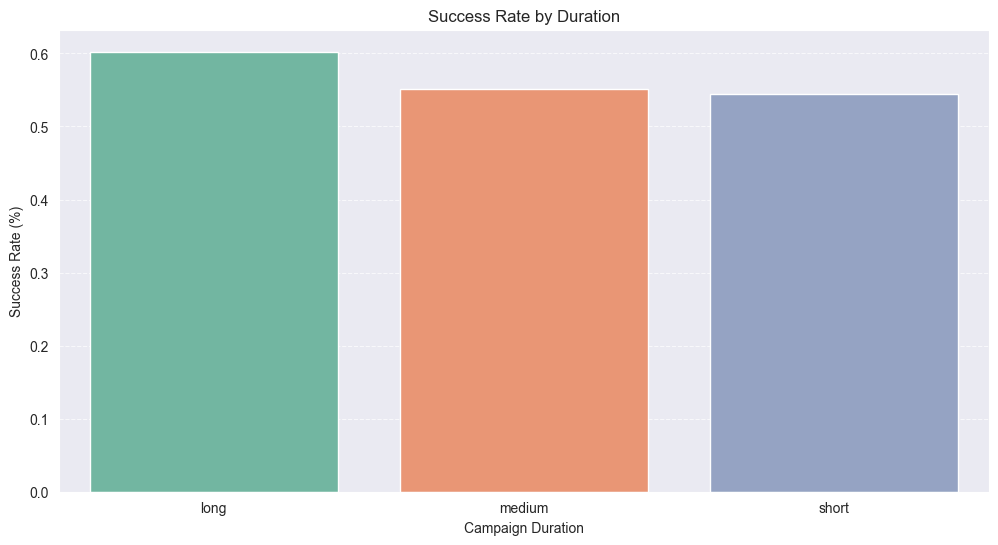

Success Rate by Duration Bin:
  duration_bin   success
0         long  0.602292
1       medium  0.551698
2        short  0.544671


In [68]:
# Bar Plot of success rate by duration category

success_rate_by_duration = df.groupby("duration_bin")["success"].mean().reset_index()


plt.figure(figsize=(12,6))
sns.barplot(data=success_rate_by_duration,x="duration_bin",y="success",palette="Set2")
plt.title("Success Rate by Duration")
plt.xlabel("Campaign Duration")
plt.ylabel("Success Rate (%)")
plt.grid(axis="y",linestyle="--",alpha=0.7)
plt.show()

print("Success Rate by Duration Bin:")
print(success_rate_by_duration)



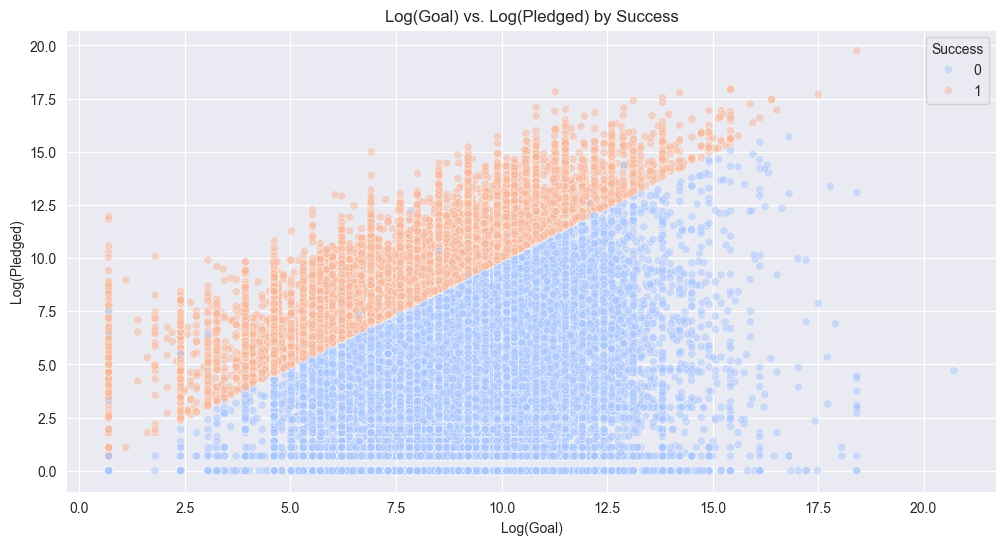

In [69]:
# Log-Scale Relationship: Goal vs. Pledged

plt.figure(figsize=(12,6))
sns.scatterplot(data=df,x="log_goal",y="log_pledged",hue="success",alpha=0.5,palette="coolwarm")
plt.title("Log(Goal) vs. Log(Pledged) by Success")
plt.xlabel("Log(Goal)")
plt.ylabel("Log(Pledged)")
plt.grid(True)
plt.legend(title="Success")
plt.show()








In [70]:
df.columns

Index(['backers_count', 'blurb', 'converted_pledged_amount',
       'country_displayable_name', 'currency', 'current_currency',
       'disable_communication', 'fx_rate', 'goal', 'id', 'is_disliked',
       'is_launched', 'is_liked', 'is_starrable', 'launched_at', 'name',
       'percent_funded', 'pledged', 'prelaunch_activated', 'slug', 'spotlight',
       'staff_pick', 'state', 'state_changed_at', 'static_usd_rate',
       'usd_exchange_rate', 'usd_pledged', 'usd_type', 'month',
       'is_in_post_campaign_pledging_phase', 'category_name', 'subcategory',
       'city', 'year_month', 'year_month_final', 'state_changed_month',
       'months_to_final_state', 'final_state_numeric', 'pledged_success_ratio',
       'success', 'duration_bin', 'log_goal', 'log_pledged', 'log_backers'],
      dtype='object')

In [71]:
df.to_csv("edadataset.csv",index=False)

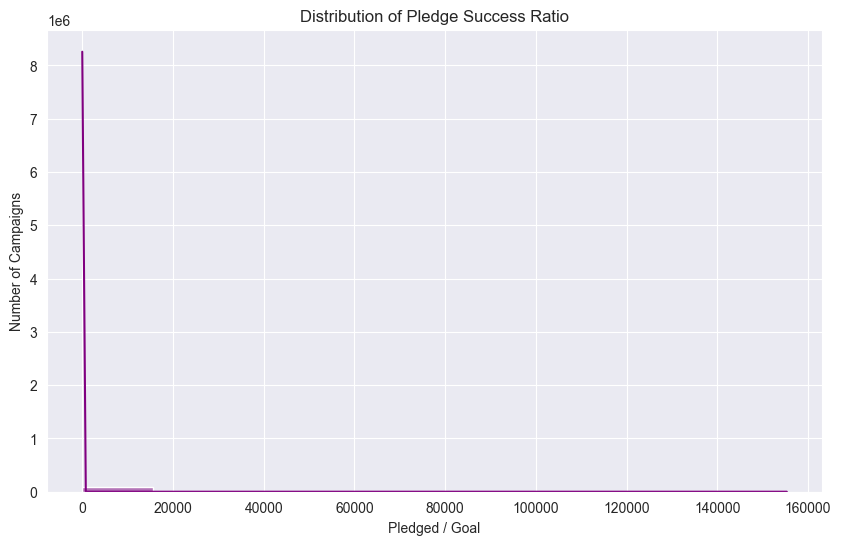

In [13]:
# Pledged Success Ratio Distribution

plt.figure(figsize=(10,6))
sns.histplot(df["pledged_success_ratio"],bins=10,kde=True,color='purple')
plt.title("Distribution of Pledge Success Ratio")
plt.xlabel("Pledged / Goal")
plt.ylabel("Number of Campaigns")
plt.grid(True)
plt.show()

/var/folders/pd/p7n06std6nj_26fw2tft4t700000gn/T/ipykernel_93462/3366893454.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered, x='category_name', y='pledged_success_ratio', showfliers=False, palette='coolwarm')


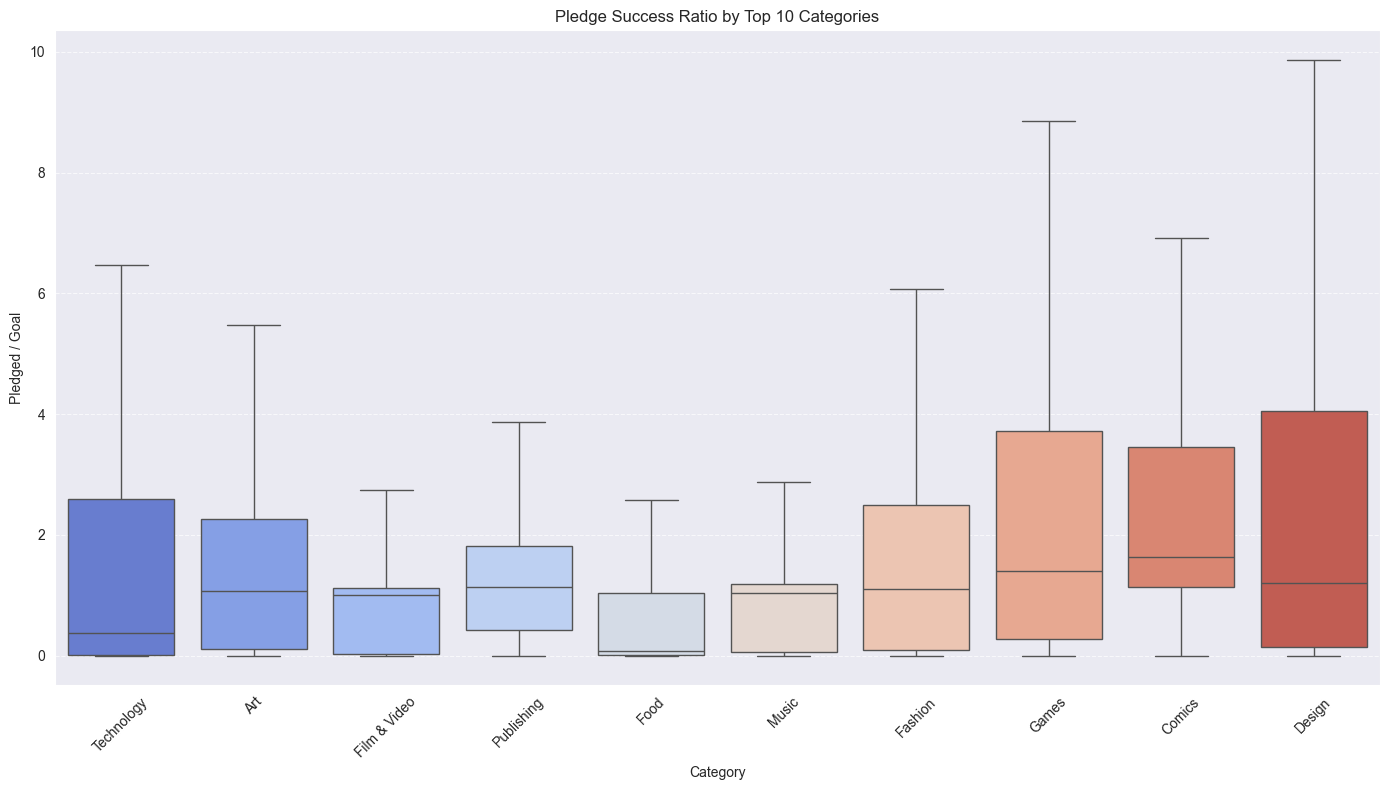

In [72]:
plt.figure(figsize=(14, 8))
top_categories = df['category_name'].value_counts().head(10).index
filtered = df[df['category_name'].isin(top_categories)]

sns.boxplot(data=filtered, x='category_name', y='pledged_success_ratio', showfliers=False, palette='coolwarm')
plt.xticks(rotation=45)
plt.title("Pledge Success Ratio by Top 10 Categories")
plt.xlabel("Category")
plt.ylabel("Pledged / Goal")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [76]:
np.median(df["pledged_success_ratio"])

np.float64(1.0371428571428571)

/var/folders/pd/p7n06std6nj_26fw2tft4t700000gn/T/ipykernel_93462/771747805.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered, x='category_name', y='pledged_success_ratio', showfliers=False, palette='coolwarm')


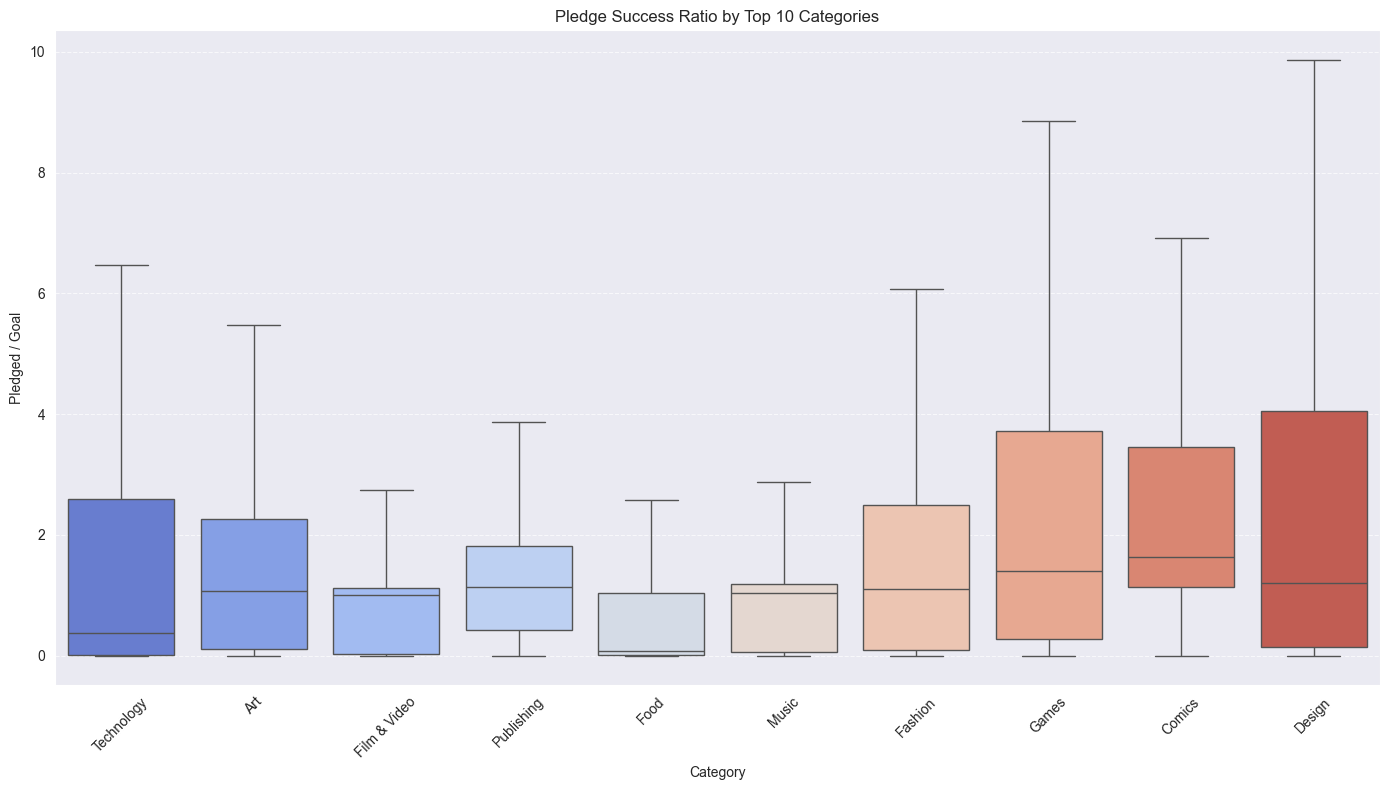

In [15]:
top_categories = df['category_name'].value_counts().head(10).index
filtered = df[df['category_name'].isin(top_categories)]

plt.figure(figsize=(14, 8))
sns.boxplot(data=filtered, x='category_name', y='pledged_success_ratio', showfliers=False, palette='coolwarm')
plt.xticks(rotation=45)
plt.title("Pledge Success Ratio by Top 10 Categories")
plt.xlabel("Category")
plt.ylabel("Pledged / Goal")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [36]:
# Drop duplicates based on only prelaunch modeling features + target
df_model = df[prelaunch_features + ['success']].drop_duplicates().reset_index(drop=True)


In [37]:
X = df_model[prelaunch_features]
y = df_model['success']


In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [39]:
overlap = set(X_train.apply(lambda row: hash(tuple(row)), axis=1)) & \
          set(X_test.apply(lambda row: hash(tuple(row)), axis=1))
print(f"✅ Train/Test overlap (by row hash match): {len(overlap)}")


✅ Train/Test overlap (by row hash match): 0


In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# ------------------------------
# Preprocessing setup
# ------------------------------

# Define pre-launch features and target
prelaunch_features = [
    'goal', 'log_goal',
    'category_name', 'subcategory', 'currency',
    'country_displayable_name', 'city', 'month',
    'staff_pick'  # ✅ OK at launch
]

target = 'success'

X = df_model[prelaunch_features].copy()
y = df_model[target].copy()

# Convert binary bools to ints
X['staff_pick'] = X['staff_pick'].astype(int)

# Define feature groups
numeric_features = ['goal', 'log_goal']
categorical_features = ['category_name', 'subcategory', 'currency', 'country_displayable_name', 'city', 'month']
binary_features = ['staff_pick']

# Preprocessors
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

binary_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features),
    ('bin', binary_transformer, binary_features)
])

# ------------------------------
# Define models to compare
# ------------------------------
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# ------------------------------
# Train/test split
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# ------------------------------
# Evaluate each model
# ------------------------------
for name, clf in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', clf)
    ])
    print(f"\n🔍 {name}")

    # Cross-validated accuracy
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
    print(f"CV Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

    # Fit and evaluate on test set
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    print("Test Accuracy:", accuracy_score(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))



🔍 Random Forest
CV Accuracy: 0.7994 ± 0.0009
Test Accuracy: 0.8025193243630118
[[5816 1599]
 [1850 8200]]
              precision    recall  f1-score   support

           0       0.76      0.78      0.77      7415
           1       0.84      0.82      0.83     10050

    accuracy                           0.80     17465
   macro avg       0.80      0.80      0.80     17465
weighted avg       0.80      0.80      0.80     17465


🔍 Logistic Regression
CV Accuracy: 0.8173 ± 0.0011
Test Accuracy: 0.8205553965073004
[[6231 1184]
 [1950 8100]]
              precision    recall  f1-score   support

           0       0.76      0.84      0.80      7415
           1       0.87      0.81      0.84     10050

    accuracy                           0.82     17465
   macro avg       0.82      0.82      0.82     17465
weighted avg       0.83      0.82      0.82     17465


🔍 XGBoost


/opt/anaconda3/envs/KickstarterProject/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:53:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/KickstarterProject/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:54:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/KickstarterProject/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:54:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/KickstarterProject/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:54:25] WARNING: /Users/runner/work/xgboost/xgboost/src/lear

CV Accuracy: 0.8172 ± 0.0026


/opt/anaconda3/envs/KickstarterProject/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:54:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Test Accuracy: 0.8184941311193816
[[6322 1093]
 [2077 7973]]
              precision    recall  f1-score   support

           0       0.75      0.85      0.80      7415
           1       0.88      0.79      0.83     10050

    accuracy                           0.82     17465
   macro avg       0.82      0.82      0.82     17465
weighted avg       0.83      0.82      0.82     17465



In [42]:
overlap = set(X_train.apply(lambda row: hash(tuple(row)), axis=1)) & \
          set(X_test.apply(lambda row: hash(tuple(row)), axis=1))
print(f"✅ Train/Test overlap (by row hash match): {len(overlap)}")

✅ Train/Test overlap (by row hash match): 0


In [45]:
from sklearn.model_selection import GridSearchCV

# Define the XGBoost pipeline again for tuning
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

# Parameter grid for tuning
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.8, 1.0]
}

# GridSearchCV
grid_search = GridSearchCV(
    xgb_pipeline,
    param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit on training data
grid_search.fit(X_train, y_train)

print("✅ Best XGBoost Parameters:", grid_search.best_params_)
print("✅ Best CV Accuracy:", grid_search.best_score_)


Fitting 3 folds for each of 36 candidates, totalling 108 fits


/opt/anaconda3/envs/KickstarterProject/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:07:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/KickstarterProject/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:07:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/KickstarterProject/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:07:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/KickstarterProject/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:07:05] WARNING: /Users/runner/work/xgboost/xgboost/src/lear

✅ Best XGBoost Parameters: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 7, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}
✅ Best CV Accuracy: 0.8187205469904378


/var/folders/pd/p7n06std6nj_26fw2tft4t700000gn/T/ipykernel_93462/548556793.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(20), x='Importance', y='Feature', palette='viridis')


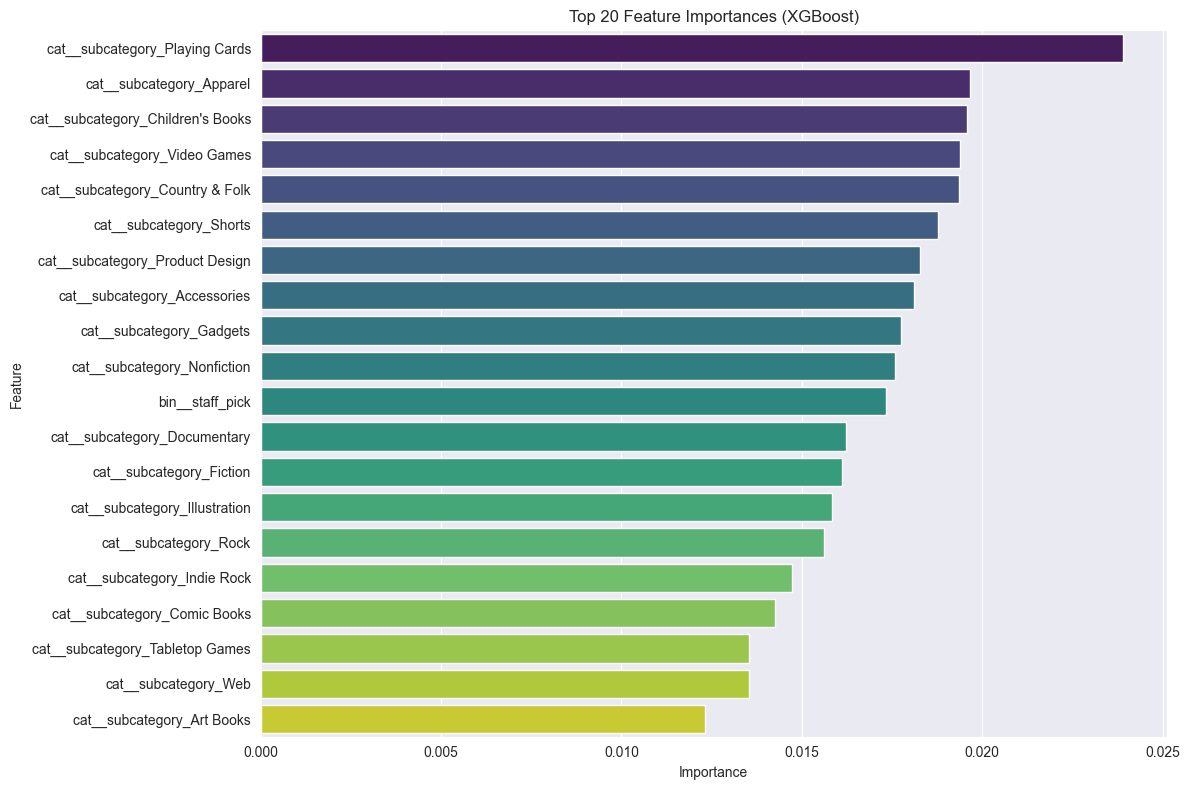

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get best estimator and fitted model
best_model = grid_search.best_estimator_

# Extract feature names after preprocessing
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
xgb_final = best_model.named_steps['classifier']

# Get feature importances
importances = xgb_final.feature_importances_

# Create DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(data=importance_df.head(20), x='Importance', y='Feature', palette='viridis')
plt.title("Top 20 Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()


In [47]:
# Get predictions
y_pred = best_model.predict(X_test)
X_test_orig = X_test.copy()
X_test_orig['y_true'] = y_test
X_test_orig['y_pred'] = y_pred

# Evaluate by country
country_perf = (
    X_test_orig.groupby('country_displayable_name')
    .apply(lambda g: pd.Series({
        'accuracy': (g['y_true'] == g['y_pred']).mean(),
        'support': len(g)
    }))
    .sort_values(by='accuracy', ascending=False)
)

# Evaluate by category
category_perf = (
    X_test_orig.groupby('category_name')
    .apply(lambda g: pd.Series({
        'accuracy': (g['y_true'] == g['y_pred']).mean(),
        'support': len(g)
    }))
    .sort_values(by='accuracy', ascending=False)
)

print("\n🎯 Accuracy by Country:")
print(country_perf.head(10))

print("\n🎯 Accuracy by Category:")
print(category_perf.head(10))



🎯 Accuracy by Country:
                          accuracy  support
country_displayable_name                   
Luxembourg                1.000000      7.0
Greece                    1.000000     29.0
Italy                     0.887640    356.0
Poland                    0.882353     68.0
New Zealand               0.864865     74.0
the Netherlands           0.844961    129.0
Mexico                    0.844444    450.0
Ireland                   0.842105     76.0
Japan                     0.840909    132.0
Canada                    0.830044    912.0

🎯 Accuracy by Category:
               accuracy  support
category_name                   
Comics         0.921286    902.0
Games          0.906404   1218.0
Publishing     0.875000   2024.0
Food           0.853418   1419.0
Fashion        0.839102   1069.0
Journalism     0.834375    320.0
Design         0.821006    676.0
Technology     0.807223   1883.0
Film & Video   0.791844   2354.0
Music          0.788732   1775.0


/var/folders/pd/p7n06std6nj_26fw2tft4t700000gn/T/ipykernel_93462/363898940.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({
/var/folders/pd/p7n06std6nj_26fw2tft4t700000gn/T/ipykernel_93462/363898940.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


In [49]:
import joblib

# Save the best-performing pipeline (e.g., tuned XGBoost pipeline)
joblib.dump(best_model, "model/kickstarter_success_model.pkl")


['kickstarter_success_model.pkl']

In [51]:
df_model.to_csv("cleaned_kickstarter.csv",index=False)

In [52]:
df_model.columns

Index(['goal', 'log_goal', 'category_name', 'subcategory', 'currency',
       'country_displayable_name', 'city', 'month', 'staff_pick', 'spotlight',
       'success'],
      dtype='object')

In [53]:
df.columns

Index(['backers_count', 'blurb', 'converted_pledged_amount',
       'country_displayable_name', 'currency', 'current_currency',
       'disable_communication', 'fx_rate', 'goal', 'id', 'is_disliked',
       'is_launched', 'is_liked', 'is_starrable', 'launched_at', 'name',
       'percent_funded', 'pledged', 'prelaunch_activated', 'slug', 'spotlight',
       'staff_pick', 'state', 'state_changed_at', 'static_usd_rate',
       'usd_exchange_rate', 'usd_pledged', 'usd_type', 'month',
       'is_in_post_campaign_pledging_phase', 'category_name', 'subcategory',
       'city', 'year_month', 'year_month_final', 'state_changed_month',
       'months_to_final_state', 'final_state_numeric', 'pledged_success_ratio',
       'success', 'duration_bin', 'log_goal', 'log_pledged', 'log_backers'],
      dtype='object')

In [55]:
len(df['state'])

95029